# Predicting the charge-transfer resistance 

In this example, we use the standard 1xZARC model to illustrate how the impedance can be recovered with Gaussian processes using either the real part, the imaginary part, or both parts of the experimental impedance. Then, we illustrate how to evaluate the charge-transfer resistance as a stochastic Gaussian variable. More details can be found in: B. Py, A. Maradesa, F. Ciucci, Gaussian processes for the analysis of electrochemical impedance spectroscopy data: Prediction, filtering, and active learning, Electrochimica Acta. 439 (2023) 141688.

In [1]:
# import the libraries needed
import importlib
import GP_hilbert as gpf
importlib.reload(gpf)
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
# plot standards
plt.rc('font', family='serif', size=15)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

## 1) Define the synthetic impedance experiment $Z_{\rm exp}(\omega)$

### 1.1) Define frequency range

In [3]:
N_freqs = 81
freq_vec = np.logspace(-2., 6., num=N_freqs, endpoint=True)
omega_vec = 2.*np.pi*freq_vec

### 1.2) Define the circuit parameters

In [4]:
R_ct = 50. # Ohm
R_inf = 10. # Ohm
phi = 0.8 # dimensionless
tau_0 = 0.1 # s
L_0 = 0 # H

### 1.3) Generate exact impedance $Z_{\rm exact}(\omega)$ 

In [5]:
T = tau_0**phi/R_ct
Z_exact = R_inf +  1j*(2*np.pi*freq_vec)*L_0 + 1./(1./R_ct+T*(1j*2.*np.pi*freq_vec)**phi)

### 1.4) Generate stochastic experiment with $Z_{\rm exp}(\omega) = Z_{\rm exact}(\omega)+ \sigma_n (\varepsilon_{\rm re} + i\varepsilon_{\rm im})$ where $\varepsilon_{\rm re}$ and $\varepsilon_{\rm im}$ are independent and identically distributed normals centered with 0 mean and standard deviation equal to 1

In [6]:
rng = np.random.seed(2421975) # seed the random number generator
sigma_n_exp = 0.3
Z_exp = Z_exact + (sigma_n_exp)*(np.random.normal(0, 1, N_freqs)+1j*np.random.normal(0, 1, N_freqs))

### 1.5) Draw the Nyquist plot

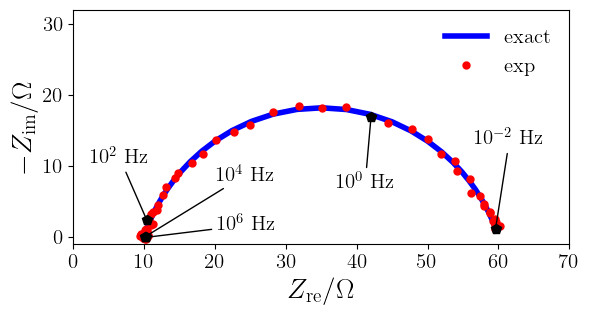

In [7]:
fig, ax = plt.subplots()
plt.plot(Z_exact.real, -Z_exact.imag, linewidth=4, color='blue', label='exact')
plt.plot(Z_exp.real, -Z_exp.imag, 'o', markersize=5, color='red', label='exp')
plt.plot(np.real(Z_exp[0:100:20]), -np.imag(Z_exp[0:100:20]), 'p', markersize=7, color='black')

plt.annotate(r'$10^{-2}$ Hz', xy=(np.real(Z_exp[0]), -np.imag(Z_exp[0])),
             xytext=(np.real(Z_exp[0])-3, 12-np.imag(Z_exp[0])),
             arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^{0}$ Hz', xy=(np.real(Z_exp[20]), -np.imag(Z_exp[20])),
             xytext=(np.real(Z_exp[20])-5, -10-np.imag(Z_exp[20])),
             arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^{2}$ Hz', xy=(np.real(Z_exp[40]), -np.imag(Z_exp[40])),
             xytext=(np.real(Z_exp[40])-8, 8-np.imag(Z_exp[40])),
             arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^{4}$ Hz', xy=(np.real(Z_exp[60]), -np.imag(Z_exp[60])),
             xytext=(np.real(Z_exp[60])+10, 8-np.imag(Z_exp[60])),
             arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^{6}$ Hz', xy=(np.real(Z_exp[80]), -np.imag(Z_exp[80])),
             xytext=(np.real(Z_exp[80])+10, 1-np.imag(Z_exp[80])),
             arrowprops=dict(arrowstyle="-", connectionstyle="arc"))

plt.legend(frameon=False, fontsize=15, loc='upper right')
plt.axis('scaled')

plt.xlim(0, 70)
plt.ylim(-1, 32)
plt.xticks(range(0, 80, 10))
plt.yticks(range(0, 40, 10))
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
plt.show()

## 2) Set the kernel options 

In [8]:
ker_opts = {
    'sigma_DRT': 1.,
    'sigma_SB': 1.,
    'ell': 1.,
    'tau_max': 10,
    'DRT': True,
    'SB': True,
    'SB_ker_type': 'IQ',
}

# these values are nominal

## 3) Fit the imaginary part of the data

### 3.1) Initialize the hyperparameters

In [9]:
sigma_n = 0.75
sigma_DRT = 11
sigma_SB = 1E-7
ell = 3
sigma_L = 5E-4

### 3.2) Maximize the experimental evidence, i.e., minimize the negative marginal log-likelihood (NMML)

In [10]:
theta_0 = np.array([sigma_n, sigma_DRT, sigma_SB, ell, sigma_L])
seq_theta = np.copy(theta_0)
def print_results(theta):
    global seq_theta
    seq_theta = np.vstack((seq_theta, theta))
    print('%.4E, %.4E, %.4E, %.4E, %.6E; evidence = %.8E'%(theta[0], theta[1], theta[2], theta[3], theta[4], gpf.NMLL_fct(theta, Z_exp.imag, omega_vec, ker_opts, 'im')))
    
res = minimize(gpf.NMLL_fct, theta_0, args=(Z_exp.imag, omega_vec, ker_opts, 'im'), method='Powell', \
               callback=print_results, options={'disp': True, 'xtol': 1E-6, 'ftol': 1E-6})
res = minimize(gpf.NMLL_fct, res.x, args=(Z_exp.imag, omega_vec, ker_opts, 'im'), method='Nelder-Mead', \
                callback=print_results, options={'disp': True, 'xatol': 1E-6, 'fatol': 1E-6})

theta_im = res.x
sigma_n, sigma_DRT, sigma_SB, ell, sigma_L = theta_im

2.8806E-01, 2.9187E+01, 4.6189E-06, 2.9958E+00, 3.510221E-08; evidence = -2.83229351E+01
2.8081E-01, 2.9261E+01, 1.2284E-08, 5.6134E+00, 2.664847E-14; evidence = -2.88474587E+01
2.7954E-01, 2.9254E+01, 1.1514E-08, 8.2309E+00, 2.664847E-14; evidence = -2.88488289E+01
2.7954E-01, 2.9254E+01, -6.9070E-08, 1.0210E+01, 2.664847E-14; evidence = -2.88488289E+01
Optimization terminated successfully.
         Current function value: -28.848829
         Iterations: 4
         Function evaluations: 517
2.7954E-01, 2.9254E+01, -6.9070E-08, 1.0210E+01, 2.664847E-14; evidence = -2.88488289E+01
2.7954E-01, 2.9254E+01, -6.9070E-08, 1.0210E+01, 2.664847E-14; evidence = -2.88488289E+01
2.7954E-01, 2.9254E+01, -6.9070E-08, 1.0210E+01, 2.664847E-14; evidence = -2.88488289E+01
2.7954E-01, 2.9254E+01, -6.9070E-08, 1.0210E+01, 2.664847E-14; evidence = -2.88488289E+01
2.7954E-01, 2.9254E+01, -6.9070E-08, 1.0210E+01, 2.664847E-14; evidence = -2.88488289E+01
2.7954E-01, 2.9254E+01, -6.9070E-08, 1.0210E+01, 2.66

2.7954E-01, 2.9254E+01, -6.9076E-08, 1.0211E+01, 2.665107E-14; evidence = -2.88488289E+01
2.7954E-01, 2.9254E+01, -6.9076E-08, 1.0211E+01, 2.665107E-14; evidence = -2.88488289E+01
2.7954E-01, 2.9254E+01, -6.9076E-08, 1.0211E+01, 2.665107E-14; evidence = -2.88488289E+01
2.7954E-01, 2.9254E+01, -6.9076E-08, 1.0211E+01, 2.665107E-14; evidence = -2.88488289E+01
2.7954E-01, 2.9254E+01, -6.9076E-08, 1.0211E+01, 2.665107E-14; evidence = -2.88488289E+01
2.7954E-01, 2.9254E+01, -6.9076E-08, 1.0211E+01, 2.665107E-14; evidence = -2.88488289E+01
2.7954E-01, 2.9254E+01, -6.9076E-08, 1.0211E+01, 2.665107E-14; evidence = -2.88488289E+01
2.7954E-01, 2.9254E+01, -6.9076E-08, 1.0211E+01, 2.665107E-14; evidence = -2.88488289E+01
Optimization terminated successfully.
         Current function value: -28.848829
         Iterations: 96
         Function evaluations: 252


In [11]:
# update the values of the kernels as the gpf functions simply copy ker_opts
ker_opts['sigma_SB'] = sigma_SB
ker_opts['ell'] = ell
ker_opts['sigma_DRT'] = sigma_DRT

### 3.3) Check if the results are reasonable

### 3.3.1) Check $L_0$

We predict the value $\bar{L_0}$ of $L_{0}$ as

$$
\bar{L_0} = \frac {\boldsymbol \omega^\top (\mathbf K_{\rm im} + \sigma_{n}^{2} \mathbf{I})^{-1} \mathbf Z_{\rm exp,im}(\boldsymbol \omega)} {\sigma_{L}^{-2} + \boldsymbol \omega^\top (\mathbf K_{\rm im} + \sigma_{n}^{2} \mathbf{I})^{-1} \boldsymbol \omega} 
$$

More details in: A. O'Hagan, Curve fitting and optimal design for prediction, J. R. Stat. Soc. Ser. B 40 (1) (1978) 1-24.

In [12]:
K_im = gpf.mat_K(omega_vec, omega_vec, ker_opts, 'im')
Sigma = (sigma_n**2)*np.eye(N_freqs)
K_full = K_im + Sigma + (sigma_L**2)*np.outer(omega_vec, omega_vec)
K_full_reg = K_im + Sigma

# Cholesky-decompose K_full
if not gpf.is_PD(K_full_reg):
    K_full_reg = gpf.nearest_PD(K_full_reg)

# inverse of K_im
L = np.linalg.cholesky(K_full_reg)
inv_L = np.linalg.inv(L)
inv_K_full_reg = np.dot(inv_L.T, inv_L)

num_L_0 = omega_vec@(inv_K_full_reg@Z_exp.imag)
den_L_0 = (sigma_L**-2) + omega_vec@(inv_K_full_reg@omega_vec)
L_0_est = num_L_0/den_L_0

print('L_0_est = %.6E H vs. L_0 = %.6E H'%(L_0_est, L_0))

L_0_est = 2.328629E-21 H vs. L_0 = 0.000000E+00 H


### 3.3.2) Check the fit of $\Im(Z_{\rm exp})$ against the GP

### 3.3.2.1) Run the GP regression

In [13]:
# Cholesky-decompose K_full
if not gpf.is_PD(K_full):
    K_full = gpf.nearest_PD(K_full)

# cholesky factorization
L = np.linalg.cholesky(K_full)

# covariance matrix
inv_L = np.linalg.inv(L)
inv_K_full = np.dot(inv_L.T, inv_L)

N_star_freqs = N_freqs
freq_star_vec = np.copy(freq_vec) #np.logspace(-4., 4., num=N_star_freqs, endpoint=True)
omega_star_vec = 2.*np.pi*freq_star_vec

mu_star_vec = np.zeros_like(omega_star_vec)
sigma_star_vec = np.zeros_like(omega_star_vec)

for index, omega_star in enumerate(omega_star_vec):
    
    #print('iter = ', index+1, '/', N_star_freqs)
    omega_star_np = np.array([omega_star])
    k_star_star = gpf.mat_K(omega_star_np, omega_star_np, ker_opts, 'im').flatten() + (sigma_L**2)*omega_star_np**2
    k_star = gpf.mat_K(omega_star_np, omega_vec, ker_opts, 'im').flatten() + (sigma_L**2)*omega_vec*omega_star_np
    
    mu_star_vec[index] = k_star@(inv_K_full@Z_exp.imag)
    sigma_star_vec[index] = np.sqrt(k_star_star - k_star@(inv_K_full@k_star))

### 3.3.2.2) Plot the outcome of the GP regression

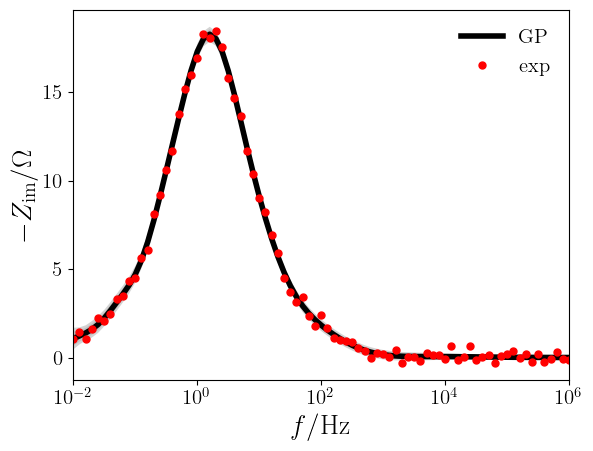

In [14]:
plt.fill_between(freq_star_vec, -mu_star_vec-3*sigma_star_vec, -mu_star_vec+3*sigma_star_vec,  facecolor='lightgrey')
plt.fill_between(freq_star_vec, -mu_star_vec-2*sigma_star_vec, -mu_star_vec+2*sigma_star_vec,  facecolor='silver')
plt.fill_between(freq_star_vec, -mu_star_vec-sigma_star_vec, -mu_star_vec+sigma_star_vec,  facecolor='grey')
plt.semilogx(freq_star_vec, -mu_star_vec, linewidth=4, color='black', label='GP')
plt.semilogx(freq_vec,  -Z_exp.imag, 'o', markersize=5, color='red', label='exp')
plt.xlim(1E-2, 1E6)
plt.xscale('log')
plt.xlabel(r'$f/{\rm Hz}$', fontsize=20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize=20)
plt.legend(frameon=False, fontsize = 15)
plt.show()

## 4) Fit the real part of the data

### 4.1) Initialize the hyperparameters

In [15]:
sigma_n = 0.75
sigma_DRT = 11
sigma_SB = 1E-7
ell = 3
sigma_R = 5E-4

### 4.2) Minimize the NMLL

In [16]:
theta_0 = np.array([sigma_n, sigma_DRT, sigma_SB, ell, sigma_R])
seq_theta = np.copy(theta_0)
def print_results(theta):
    global seq_theta
    seq_theta = np.vstack((seq_theta, theta))
    print('%.4E, %.4E, %.4E, %.4E, %.6E; evidence = %.8E'%(theta[0], theta[1], theta[2], theta[3], theta[4], gpf.NMLL_fct(theta, Z_exp.real, omega_vec, ker_opts, 're')))
    
res = minimize(gpf.NMLL_fct, theta_0, args=(Z_exp.real, omega_vec, ker_opts, 're'), method='Powell', \
               callback=print_results, options={'disp': True, 'xtol': 1E-6, 'ftol': 1E-6})
res = minimize(gpf.NMLL_fct, res.x, args=(Z_exp.imag, omega_vec, ker_opts, 'im'), method='Nelder-Mead', \
               callback=print_results, options={'disp': True, 'xatol': 1E-6, 'fatol': 1E-6})

theta_re = res.x
sigma_n, sigma_DRT, sigma_SB, ell, sigma_R = theta_re

9.4250E+00, 8.6589E+01, 3.3633E-08, 5.6176E+00, 9.962484E+00; evidence = 1.97532240E+02
-2.9718E-01, -1.8546E+01, -2.3249E-08, 5.3016E+00, -8.297727E+00; evidence = -1.68747120E+01
-2.9486E-01, -2.6504E+01, -1.2573E-07, 5.3094E+00, -1.000312E+01; evidence = -1.91102510E+01
-2.9486E-01, -2.6506E+01, -1.5181E-07, 5.5823E+00, -1.000447E+01; evidence = -1.91102511E+01
Optimization terminated successfully.
         Current function value: -19.110251
         Iterations: 4
         Function evaluations: 478
-3.0960E-01, -2.6506E+01, -1.5181E-07, 5.5823E+00, -1.000447E+01; evidence = -1.89516198E+01
-3.0960E-01, -2.6506E+01, -1.5181E-07, 5.5823E+00, -1.000447E+01; evidence = -1.89516198E+01
-3.0960E-01, -2.6506E+01, -1.5181E-07, 5.5823E+00, -1.000447E+01; evidence = -1.89516198E+01
-3.0960E-01, -2.6506E+01, -1.5181E-07, 5.5823E+00, -1.000447E+01; evidence = -1.89516198E+01
-3.0133E-01, -2.5816E+01, -1.5106E-07, 5.4947E+00, -1.022409E+01; evidence = -1.90667720E+01
-3.0133E-01, -2.5816E+01, -1

-3.0078E-01, -2.6001E+01, -1.5146E-07, 5.5070E+00, -1.019801E+01; evidence = -1.90769886E+01
-3.0078E-01, -2.6001E+01, -1.5146E-07, 5.5070E+00, -1.019801E+01; evidence = -1.90769886E+01
-3.0078E-01, -2.6001E+01, -1.5146E-07, 5.5070E+00, -1.019801E+01; evidence = -1.90769886E+01
-3.0078E-01, -2.6001E+01, -1.5146E-07, 5.5070E+00, -1.019801E+01; evidence = -1.90769886E+01
-3.0078E-01, -2.6001E+01, -1.5146E-07, 5.5070E+00, -1.019801E+01; evidence = -1.90769886E+01
-3.0078E-01, -2.6001E+01, -1.5146E-07, 5.5070E+00, -1.019801E+01; evidence = -1.90769886E+01
-3.0078E-01, -2.6001E+01, -1.5146E-07, 5.5070E+00, -1.019801E+01; evidence = -1.90769886E+01
-3.0078E-01, -2.6001E+01, -1.5146E-07, 5.5070E+00, -1.019801E+01; evidence = -1.90769886E+01
-3.0078E-01, -2.6001E+01, -1.5146E-07, 5.5070E+00, -1.019801E+01; evidence = -1.90769886E+01
-3.0078E-01, -2.6001E+01, -1.5146E-07, 5.5070E+00, -1.019801E+01; evidence = -1.90769886E+01
-3.0078E-01, -2.6001E+01, -1.5146E-07, 5.5070E+00, -1.019801E+01; evid

-3.0078E-01, -2.6001E+01, -1.5146E-07, 5.5070E+00, -1.019801E+01; evidence = -1.90769886E+01
-3.0078E-01, -2.6001E+01, -1.5146E-07, 5.5070E+00, -1.019801E+01; evidence = -1.90769886E+01
-3.0078E-01, -2.6001E+01, -1.5146E-07, 5.5070E+00, -1.019801E+01; evidence = -1.90769886E+01
-3.0078E-01, -2.6001E+01, -1.5146E-07, 5.5070E+00, -1.019801E+01; evidence = -1.90769886E+01
-3.0078E-01, -2.6001E+01, -1.5146E-07, 5.5070E+00, -1.019801E+01; evidence = -1.90769886E+01
-3.0078E-01, -2.6001E+01, -1.5146E-07, 5.5070E+00, -1.019801E+01; evidence = -1.90769886E+01
-3.0078E-01, -2.6001E+01, -1.5146E-07, 5.5070E+00, -1.019801E+01; evidence = -1.90769886E+01
-3.0078E-01, -2.6001E+01, -1.5146E-07, 5.5070E+00, -1.019801E+01; evidence = -1.90769886E+01
-3.0078E-01, -2.6001E+01, -1.5146E-07, 5.5070E+00, -1.019801E+01; evidence = -1.90769886E+01
-3.0078E-01, -2.6001E+01, -1.5146E-07, 5.5070E+00, -1.019801E+01; evidence = -1.90769886E+01
-3.0078E-01, -2.6001E+01, -1.5146E-07, 5.5070E+00, -1.019801E+01; evid

C:\Users\user\AppData\Local\Temp\ipykernel_22284\3847721447.py:10: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res = minimize(gpf.NMLL_fct, res.x, args=(Z_exp.imag, omega_vec, ker_opts, 'im'), method='Nelder-Mead', \


In [17]:
# update the values of the kernel
# as the gpf functions simply copy ker_opts
ker_opts['sigma_SB'] = sigma_SB
ker_opts['ell'] = ell
ker_opts['sigma_DRT'] = sigma_DRT

### 4.3) Check if the results are reasonable

### 4.3.1) Check $R_\infty$

We predict the value $\bar{R_\infty}$ of $R_\infty$ as

$$
\bar{R_\infty} = \frac {\boldsymbol 1^\top (\mathbf K_{\rm re} + \sigma_{n}^{2} \mathbf{I})^{-1} \mathbf Z_{\rm exp,re}(\boldsymbol \omega)} {\sigma_{\rm R}^{-2} + \boldsymbol 1^\top (\mathbf K_{\rm re} + \sigma_{n}^{2} \mathbf{I})^{-1} \boldsymbol 1} 
$$

where $\boldsymbol 1$ is the column vector of size $N_{\rm freqs}$ ($N_{\rm freqs}$ is the numnber of probed frequencies) whose components are all equal to 1 (more details in: J. Liu, F. Ciucci, The Gaussian process distribution of relaxation times: A machine learning tool for the analysis and prediction of electrochemical impedance spectroscopy data, Electrochim. Acta. 331 (2020) 135316.).

In [18]:
K_re = gpf.mat_K(omega_vec, omega_vec, ker_opts, 're')
Sigma = (sigma_n**2)*np.eye(N_freqs)
K_full = K_re + Sigma + (sigma_R**2)*np.ones_like(Sigma)
K_full_reg = K_re + Sigma

# Cholesky-decompose K_full
if not gpf.is_PD(K_full_reg):
    K_full_reg = gpf.nearest_PD(K_full_reg)

# inverse of K_re
L = np.linalg.cholesky(K_full_reg)
inv_L = np.linalg.inv(L)
inv_K_full_reg = np.dot(inv_L.T, inv_L)

num_R_inf = np.ones(N_freqs)@(inv_K_full_reg@Z_exp.real)
den_R_inf = (sigma_R**-2) + np.ones(N_freqs)@(inv_K_full_reg@np.ones(N_freqs))
R_inf_est = num_R_inf/den_R_inf

print('R_inf_est = %.6E Ohm vs. R_inf = %.6E Ohm'%(R_inf_est, R_inf))

R_inf_est = 1.000436E+01 Ohm vs. R_inf = 1.000000E+01 Ohm


### 4.3.2) Check the fit of $\Re(Z_{\rm exp})$ against the GP

### 4.3.2.1) Run the GP regression

In [19]:
# Cholesky-decompose K_full
if not gpf.is_PD(K_full):
    K_full = gpf.nearest_PD(K_full)

# cholesky factorization
L = np.linalg.cholesky(K_full)

# covariance matrix
inv_L = np.linalg.inv(L)
inv_K_full = np.dot(inv_L.T, inv_L)

N_star_freqs = N_freqs
freq_star_vec = np.copy(freq_vec) #np.logspace(-4., 4., num=N_star_freqs, endpoint=True)
omega_star_vec = 2.*np.pi*freq_star_vec

mu_star_vec = np.zeros_like(omega_star_vec)
sigma_star_vec = np.zeros_like(omega_star_vec)

for index, omega_star in enumerate(omega_star_vec):
    #print('iter = ', index+1, '/', N_star_freqs)
    omega_star_np = np.array([omega_star])
    
    k_star_star = gpf.mat_K(omega_star_np, omega_star_np, ker_opts, 're').flatten() + (sigma_R**2)
    k_star = gpf.mat_K(omega_star_np, omega_vec, ker_opts, 're').flatten() + (sigma_R**2)*np.ones(N_freqs)

    mu_star_vec[index] = k_star@(inv_K_full@Z_exp.real)
    sigma_star_vec[index] = np.sqrt(k_star_star - k_star@(inv_K_full@k_star))

### 4.3.2.2) Plot the outcome of the GP regression

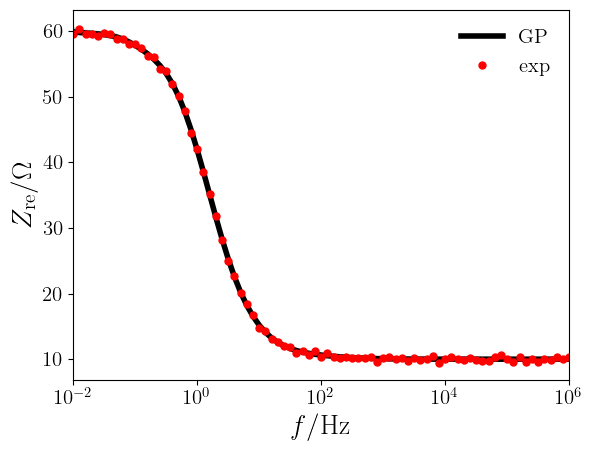

In [20]:
plt.fill_between(freq_star_vec, mu_star_vec-3*sigma_star_vec, mu_star_vec+3*sigma_star_vec,  facecolor='lightgrey')
plt.fill_between(freq_star_vec, mu_star_vec-2*sigma_star_vec, mu_star_vec+2*sigma_star_vec,  facecolor='silver')
plt.fill_between(freq_star_vec, mu_star_vec-sigma_star_vec, mu_star_vec+sigma_star_vec,  facecolor='grey')
plt.semilogx(freq_star_vec, mu_star_vec, linewidth=4, color='black', label='GP')
plt.semilogx(freq_vec,  Z_exp.real, 'o', markersize=5, color='red', label='exp')
plt.xlim(1E-2, 1E6)
plt.xscale('log')
plt.xlabel(r'$f/{\rm Hz}$', fontsize=20)
plt.ylabel(r'$Z_{\rm re}/\Omega$', fontsize=20)
plt.legend(frameon=False, fontsize = 15)
plt.show()

## 5) Bundle things together

In [21]:
Z_exp_all = np.zeros(2*N_freqs)
Z_exp_all[:N_freqs] = Z_exp.real
Z_exp_all[N_freqs:] = Z_exp.imag

### 5.1) Initialize the hyperparameters

In [22]:
sigma_n, sigma_DRT, sigma_SB, ell = 0.5*(abs(theta_re[:4])+abs(theta_im[:4]))
sigma_R = abs(theta_re[-1])
sigma_L = abs(theta_im[-1])

In [ ]:
theta_0 = [sigma_n, sigma_DRT, sigma_SB, ell, sigma_R, sigma_L]
seq_theta = np.copy(theta_0)

def print_results(theta):
    global seq_theta
    seq_theta = np.vstack((seq_theta, theta))
    print('%.4E, %.4E, %.4E, %.4E %.4E, %.6E; evidence = %.8E'%(theta[0], theta[1], theta[2], theta[3], theta[4], theta[5], gpf.NMLL_fct(theta, Z_exp_all, omega_vec, ker_opts, 'all')))
    
res = minimize(gpf.NMLL_fct, theta_0, args=(Z_exp_all, omega_vec, ker_opts, 'all'), method='Powell', \
               callback=print_results, options={'disp': True, 'xtol': 1E-6, 'ftol': 1E-6})
#res = minimize(gpf.NMLL_fct, res.x, args=(Z_exp.imag, omega_vec, ker_opts, 'im'), method='Nelder-Mead', \
               #callback=print_results, options={'disp': True, 'xatol': 1E-6, 'fatol': 1E-6})

theta = res.x
sigma_n, sigma_DRT, sigma_SB, ell, sigma_R, sigma_L = theta

2.8491E-01, 2.6651E+01, 2.7594E-07, 7.1803E+00 9.9934E+00, 2.665107E-14; evidence = -7.80203785E+01


In [ ]:
# update the values of the kernel as the gpf functions simply copy ker_opts
ker_opts['sigma_SB'] = sigma_SB
ker_opts['ell'] = ell
ker_opts['sigma_DRT'] = sigma_DRT

tau_max = 10 # s

### 5.2) Check if the results are reasonable

Compute the blocks in the covariance matrix defined in equation (6c) of the main manuscript.

In [ ]:
K_re = gpf.mat_K(omega_vec, omega_vec, ker_opts, 're')
K_im = gpf.mat_K(omega_vec, omega_vec, ker_opts, 'im')
K_re_im = gpf.mat_K(omega_vec, omega_vec, ker_opts, 're-im')
K_im_re = gpf.mat_K(omega_vec, omega_vec, ker_opts, 'im-re')

Assemble the covariance matrix defined in equation (6c).

In [ ]:
Sigma = sigma_n**2*np.eye(N_freqs)
K_full = np.zeros((2*N_freqs, 2*N_freqs))
K_full[:N_freqs, :N_freqs] = K_re + Sigma + (sigma_R**2)*np.ones(N_freqs)
K_full[:N_freqs, N_freqs:] = K_re_im
K_full[N_freqs:, :N_freqs] = K_im_re
K_full[N_freqs:, N_freqs:] = K_im + Sigma + (sigma_L**2)*np.outer(omega_vec, omega_vec)

Ensure the full covariance matrix is positive definite, and, if not, replace it with its nearest positive definite matrix.

In [ ]:
if not gpf.is_PD(K_full):
    K_full = gpf.nearest_PD(K_full)

Compute the Cholesky factorisation of the full covariance matrix to evaluate its inverse.

In [ ]:
# cholesky factorisation
L = np.linalg.cholesky(K_full)

# covariance matrix
inv_L = np.linalg.inv(L)
inv_K_full = np.dot(inv_L.T, inv_L)

### 5.2.1) Run the GP regression

In [ ]:
N_star_freqs = N_freqs
freq_star_vec = np.copy(freq_vec)
omega_star_vec = 2.*np.pi*freq_star_vec

mu_re_star_vec = np.zeros_like(omega_star_vec)
sigma_re_star_vec = np.zeros_like(omega_star_vec)

mu_im_star_vec = np.zeros_like(omega_star_vec)
sigma_im_star_vec = np.zeros_like(omega_star_vec)


for index, omega_star in enumerate(omega_star_vec):
    
    #print('iter = ', index+1, '/', N_star_freqs)
    omega_star_np = np.array([omega_star])
    
    # k_star_star # equation (6a)
    k_star_star_re = gpf.mat_K(omega_star_np, omega_star_np, ker_opts, 're').flatten() + (sigma_R**2) 
    k_star_star_im = gpf.mat_K(omega_star_np, omega_star_np, ker_opts, 'im').flatten() + (sigma_L**2)*omega_star_np**2
    
    # k_star # equation (6b)
    k_star_re_re = gpf.mat_K(omega_star_np, omega_vec, ker_opts, 're').flatten() + (sigma_R**2)*np.ones(N_freqs)
    k_star_re_im = gpf.mat_K(omega_star_np, omega_vec, ker_opts, 're-im').flatten()
    k_star_im_re = gpf.mat_K(omega_star_np, omega_vec, ker_opts, 'im-re').flatten()
    k_star_im_im = gpf.mat_K(omega_star_np, omega_vec, ker_opts, 'im').flatten() + (sigma_L**2)*omega_vec*omega_star_np

    # k_star_re
    k_star_re = np.zeros(2*N_freqs)
    k_star_re[:N_freqs] = k_star_re_re
    k_star_re[N_freqs:] = k_star_re_im
    
    # k_star_im
    k_star_im = np.zeros(2*N_freqs)
    k_star_im[:N_freqs] = k_star_im_re
    k_star_im[N_freqs:] = k_star_im_im
    
    mu_re_star_vec[index] = k_star_re@(inv_K_full@Z_exp_all) # equation (9a)
    sigma_re_star_vec[index] = np.sqrt(k_star_star_re - k_star_re@(inv_K_full@k_star_re)) # equation (9b)
    
    mu_im_star_vec[index] = k_star_im@(inv_K_full@Z_exp_all) # equation (9a)
    sigma_im_star_vec[index] = np.sqrt(k_star_star_im - k_star_im@(inv_K_full@k_star_im)) # equation (9b)

### 5.2.1.1) Plot the regressed imaginary part

In [ ]:
plt.fill_between(freq_star_vec, -mu_im_star_vec-3*sigma_im_star_vec, -mu_im_star_vec+3*sigma_im_star_vec,  facecolor='lightgrey')
plt.fill_between(freq_star_vec, -mu_im_star_vec-2*sigma_im_star_vec, -mu_im_star_vec+2*sigma_im_star_vec,  facecolor='silver')
plt.fill_between(freq_star_vec, -mu_im_star_vec-sigma_im_star_vec, -mu_im_star_vec+sigma_im_star_vec,  facecolor='grey')
plt.semilogx(freq_star_vec, -mu_im_star_vec, linewidth=4, color='black', label='GP')
plt.semilogx(freq_vec,  -Z_exp.imag, 'o', markersize=5, color='red', label='exp')
plt.xlim(1E-2, 1E6)
plt.xscale('log')
plt.xlabel(r'$f/{\rm Hz}$', fontsize=20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize=20)
plt.legend(frameon=False, fontsize = 15)
plt.show()

### 5.2.1.2) Plot the regressed real part

In [ ]:
plt.fill_between(freq_star_vec, mu_re_star_vec-3*sigma_re_star_vec, mu_re_star_vec+3*sigma_re_star_vec,  facecolor='lightgrey')
plt.fill_between(freq_star_vec, mu_re_star_vec-2*sigma_re_star_vec, mu_re_star_vec+2*sigma_re_star_vec,  facecolor='silver')
plt.fill_between(freq_star_vec, mu_re_star_vec-sigma_re_star_vec, mu_re_star_vec+sigma_re_star_vec,  facecolor='grey')
plt.semilogx(freq_star_vec, mu_re_star_vec, linewidth=4, color='black', label='GP')
plt.semilogx(freq_vec,  Z_exp.real, 'o', markersize=5, color='red', label='exp')
plt.xlim(1E-2, 1E6)
plt.xscale('log')
plt.xlabel(r'$f/{\rm Hz}$', fontsize=20)
plt.ylabel(r'$Z_{\rm re}/\Omega$', fontsize=20)
plt.legend(frameon=False, fontsize = 15)
plt.show()

### 5.2.1.3) Imaginary difference plot

In [ ]:
diff_im = -mu_im_star_vec+Z_exact.imag
sigma_diff_im = sigma_im_star_vec

In [ ]:
plt.fill_between(freq_star_vec, diff_im-3*sigma_diff_im, diff_im+3*sigma_diff_im,  facecolor='lightgrey')
plt.fill_between(freq_star_vec, diff_im-2*sigma_diff_im, diff_im+2*sigma_diff_im,  facecolor='silver')
plt.fill_between(freq_star_vec, diff_im-sigma_diff_im, diff_im+sigma_diff_im,  facecolor='grey')
plt.semilogx(freq_star_vec, diff_im, linewidth=4, color='black', label='GP')
plt.semilogx(freq_star_vec, np.zeros_like(freq_star_vec), linewidth=2, color='black', ls = ':')
plt.xlim(1E-2, 1E6)
plt.ylim(-2, 2)
plt.xscale('log')
plt.xlabel(r'$f/{\rm Hz}$', fontsize=20)
plt.ylabel(r'$\left(Z_{\rm im}-Z_{\rm im, GP}\right)/\Omega$', fontsize=20)
plt.show()

### 5.2.1.4) Real difference plot

In [ ]:
diff_re = -mu_re_star_vec+Z_exact.real
sigma_diff_re = sigma_re_star_vec

In [ ]:
plt.fill_between(freq_star_vec, diff_re-3*sigma_diff_re, diff_re+3*sigma_diff_re,  facecolor='lightgrey')
plt.fill_between(freq_star_vec, diff_re-2*sigma_diff_re, diff_re+2*sigma_diff_re,  facecolor='silver')
plt.fill_between(freq_star_vec, diff_re-sigma_diff_re, diff_re+sigma_diff_re,  facecolor='grey')
plt.semilogx(freq_star_vec, diff_re, linewidth=4, color='black', label='GP')
plt.semilogx(freq_star_vec, np.zeros_like(freq_star_vec), linewidth=2, color='black', ls = ':')
plt.xlim(1E-2, 1E6)
plt.ylim(-2, 2)
plt.xscale('log')
plt.xlabel(r'$f/{\rm Hz}$', fontsize=20)
plt.ylabel(r'$\left(Z_{\rm re}-Z_{\rm re, GP}\right)/\Omega$', fontsize=20)
plt.show()

## 6) Evaluate the charge-transfer resistance as a stochastic Gaussian variable

We recall that 

$$ 
\begin{pmatrix}
Z_{\rm re}(\omega \rightarrow 0) \\
Z_{\rm re}(\omega \rightarrow \infty) \end{pmatrix} | \; \mathbf Z = \mathbf Z_{\rm exp}
\sim \mathcal{N} \left(\bf \mu_{\rm re}(0,\infty), \mathbf \Sigma_{\rm re}(0,\infty) \right) 
$$

where 

$$
\mu_{\rm re}(0,\infty) = \begin{pmatrix}
\mu^{0}_{\rm re} \\
\mu^{\infty}_{\rm re} \end{pmatrix} = \mathbf K_{\rm re,im}(0,\infty) \mathbf K^{-1}(\bf \omega,\bf \omega) \mathbf Z_{\rm exp}
$$

$$ 
\Sigma_{\rm re}(0,\infty) = \begin{pmatrix}
\Sigma^{0}_{\rm re} & \Sigma^{0,\infty}_{\rm re} \\
\Sigma^{0,\infty}_{\rm re} & \Sigma^{\infty}_{\rm re} \end{pmatrix} = \mathbf K_{\rm re}(0,\infty) - \mathbf K_{\rm re,im}(0,\infty) \mathbf K^{-1}(\omega,\omega) \mathbf K^\top_{\rm re,im}(0,\infty) 
$$

The charge-transfer resistance $ R_{\rm ct} = Z_{\rm re}(0) - Z_{\rm re}(\infty)$ is the following Gaussian random variable

$$
R_{\rm ct} \sim \mathcal{N} \left(\mu_{R_{\rm ct}}, \mathbf \sigma^{2}_{R_{\rm ct}} \right) 
$$

where

$$
\mu_{R_{\rm ct}} = \mu^{0}_{\rm re} - \mu^{\infty}_{\rm re}
$$

$$
\sigma_{R_{\rm ct}} = \sqrt{\Sigma^{0}_{\rm re} - 2\Sigma^{0,\infty}_{\rm re} + \Sigma^{\infty}_{\rm re}}
$$

In [ ]:
K_re_0inf = np.zeros((2,2)) # equation (15a)
K_re_0inf[0,0] = tau_max*sigma_DRT**2 + sigma_R**2 + 2*sigma_SB**2 
K_re_0inf[0,1] = sigma_R**2
K_re_0inf[1,0] = sigma_R**2
K_re_0inf[1,1] = sigma_R**2 + sigma_SB**2 

K_reim_0inf = np.zeros((2, 2*N_freqs)) # equation (15b)
for i in range(N_freqs):
    K_reim_0inf[0,i] = np.arctan(tau_max*omega_vec[i])*sigma_DRT**2/omega_vec[i] + sigma_R**2 
    + gpf.k_SB(0,omega_vec[i], ker_opts, 're') 
    K_reim_0inf[0,i+N_freqs] = -np.log(1 + omega_vec[i]**2*tau_max**2)*sigma_DRT**2/(2*omega_vec[i]) - gpf.k_SB(0,omega_vec[i], ker_opts, 're-im') 
    K_reim_0inf[1,i] = sigma_R**2

# Mean of the charge-transfer resistance considered as a Gaussian random variable
mu_re_0inf = np.dot(K_reim_0inf, np.dot(inv_K_full, Z_exp_all)) # equation (17a)
mean_Rct = mu_re_0inf[0] - mu_re_0inf[1] # equation (18)
print('stochastic Rct', mean_Rct, 'Ohm') # comparison with the exact value of R_ct
print('exact', R_ct, 'Ohm')

# Standard deviation of the charge-transfer resistance considered as a Gaussian random variable
sigma_re_0inf = K_re_0inf - np.dot(K_reim_0inf, np.dot(inv_K_full, np.transpose(K_reim_0inf))) # equation (17b)
if not gpf.is_PD(sigma_re_0inf): # replace sigma_re_0inf with its nearest positive definite matrix if not positive definite
    sigma_re_0inf = gpf.nearest_PD(sigma_re_0inf)
std_Rct = np.sqrt(sigma_re_0inf[0,0] - 2*sigma_re_0inf[0,1] + sigma_re_0inf[1,1]) # equation (18)
print('std_Rct', std_Rct, 'Ohm')